In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 11 09:47:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from datetime import datetime
import logging

In [4]:
#logging 

# create run_lof folder if not exist
if not os.path.exists('/content/drive/MyDrive/DLCV_CW3/run_logs/'):
    os.mkdir('/content/drive/MyDrive/DLCV_CW3/run_logs/')


Log_Format = "%(levelname)s %(asctime)s - %(message)s"

logging.basicConfig(filename = "/content/drive/MyDrive/DLCV_CW3/run_logs/vgg_"+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+".log",
                    filemode = "a",
                    format = Log_Format, 
                    level = logging.ERROR)

logger = logging.getLogger()

logger.setLevel(logging.INFO)

# Load and normalize MNIST

In [5]:
logger.info("Loading MNIST dataset") 

mnist_data_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_data/'
mnist_save_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_VGG_results/'
mnist_fig_dir = '/content/drive/MyDrive/DLCV_CW3/MNIST_VGG_figures/'

# create folder if not exist
if not os.path.exists(mnist_save_dir):
    os.mkdir(mnist_save_dir)

if not os.path.exists(mnist_fig_dir):
    os.mkdir(mnist_fig_dir)

In [6]:
logger.info("Transforming MNIST dataset") 

mnist_transform = transforms.Compose([
    transforms.Resize(size = 224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


mnist_train_data = datasets.MNIST(root=mnist_data_dir, train=True, transform=mnist_transform, download=True)

val_size = int(len(mnist_train_data) * 0.2)
train_size = len(mnist_train_data) - val_size

mnist_train_data, mnist_val_data = random_split(mnist_train_data, [train_size, val_size])
mnist_train_loader = DataLoader(dataset=mnist_train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

mnist_val_loader = DataLoader(dataset=mnist_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

mnist_test_data = datasets.MNIST(root=mnist_data_dir, train=False, transform=mnist_transform, download=True)
mnist_test_loader = DataLoader(dataset=mnist_test_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

# Visualising the MNIST data 

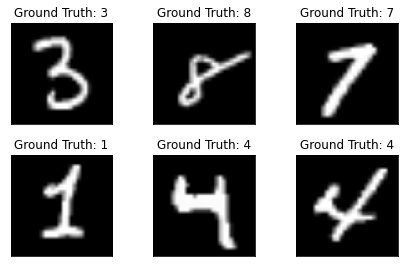

In [7]:
logger.info("Visualising MNIST dataset") 

examples = enumerate(mnist_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


# Load and normalize CIFAR10


In [8]:
logger.info("Loading Cifar dataset") 

cifar_data_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_data/'
cifar_save_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_VGG_results/'
cifar_fig_dir = '/content/drive/MyDrive/DLCV_CW3/CIFAR10_VGG_figures/'

# create folder if not exist
if not os.path.exists(cifar_save_dir):
    os.mkdir(cifar_save_dir)

if not os.path.exists(cifar_fig_dir):
    os.mkdir(cifar_fig_dir)

In [9]:
logger.info("Transforming CIFAR dataset") 

cifar_transform = transforms.Compose([
    transforms.Resize(size = 224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


cifar_train_data = datasets.CIFAR10(root=cifar_data_dir, train=True, transform=cifar_transform, download=True)

val_size = int(len(cifar_train_data) * 0.2)
train_size = len(cifar_train_data) - val_size

cifar_train_data, cifar_val_data = random_split(cifar_train_data, [train_size, val_size])
cifar_train_loader = DataLoader(dataset = cifar_train_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_val_loader = DataLoader(dataset = cifar_val_data, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)

cifar_test_data = datasets.CIFAR10(root=cifar_data_dir, train=False, transform=cifar_transform)
cifar_test_loader = DataLoader(dataset = cifar_test_data, batch_size=64, shuffle=False, num_workers=4,pin_memory=True)

cifar_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


# Visualising the CIFAR data 

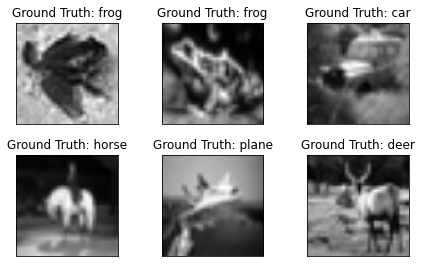

In [10]:
logger.info("Visualising CIFAR dataset") 

examples = enumerate(cifar_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(cifar_classes[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])


# VGG16 Model Class

In [11]:
VGG16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

class VGG(nn.Module):
    def __init__(self, features, class_num=10, init_weights=False):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            #nn.Dropout(p=0.5),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, class_num)
        )
        if init_weights:
            self._initialize_weights()

    
    def forward(self, x):
        x = self.features(x) 
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

   
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

def make_features(cfg: list):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)

def vgg(model_name=VGG16_config, **kwargs):
    try:
        cfg = model_name
    except:
        print("Warning: model number {} not in cfgs dict!".format(model_name))
        exit(-1)
    model = VGG(make_features(cfg), **kwargs)
    return model

In [12]:
model = vgg().cuda()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Model Training Base Code 

In [13]:
def train_model(model, model_log_path, train_loader, val_loader, loss_function, optimizer):
    
    writer = SummaryWriter(model_log_path)

    
    epochs = 10

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
  
    model = model.to(device)


    # tracking variables
    train_hist = {}
    train_hist['model_train_losses'] = []
    train_hist['model_val_losses'] = []
    train_hist['model_val_accuracies'] = []
    train_hist['model_per_epoch_ptimes'] = []
    train_hist['model_total_ptime'] = []


    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        loss_train = []    
        epoch_start_time = time.time()
        for (image, target) in tqdm(train_loader):
            image = image.to(device)

            target = target.to(device)

            ## Forward Pass
            model_optimizer.zero_grad()
            scores = model(image)
            loss = loss_function(scores,target.to(device))
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())

        val_accuracy = 0
        val_loss = []
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for (image, target) in tqdm(val_loader):
                image = image.to(device)

                target = target.to(device)
                
                scores = model(image)
                loss = loss_function(scores,target.to(device)).item()
                _, predictions = scores.max(1)
                num_correct += (predictions == target.to(device)).sum()
                num_samples += predictions.size(0)
                val_loss.append(loss)
            val_accuracy = float(num_correct) / float(num_samples)

        epoch_loss_train = np.mean(loss_train)
        epoch_val_loss = np.mean(val_loss)
        epoch_val_accuracy = val_accuracy
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        print("Training loss: %.8f, Validation loss: %.8f, Validation Accuracies: %.8f " % (epoch_loss_train, epoch_val_loss, epoch_val_accuracy))

        # record the loss for every epoch
        train_hist['model_train_losses'].append(epoch_loss_train)
        train_hist['model_val_losses'].append(epoch_val_loss)
        train_hist['model_val_accuracies'].append(epoch_val_accuracy)
        train_hist['model_per_epoch_ptimes'].append(per_epoch_ptime)
        
        writer.add_scalar("Loss/train", epoch_loss_train, epoch)
        writer.add_scalar("Loss/Val", epoch_val_loss, epoch)
        writer.add_scalar("Accuracy/val", epoch_val_accuracy, epoch)


    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['model_total_ptime'].append(total_ptime)
    
    writer.flush()
    
    writer.close()

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['model_per_epoch_ptimes']), epochs, total_ptime))
    
    
    return model, train_hist

In [14]:
def test_model(model, test_loader, loss_function):
    
    num_correct = 0
    num_samples = 0

    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
  

    test_loss = []

    for (image, target) in tqdm(test_loader):
        image = image.to(device)

        target = target.to(device)
        
        scores = model(image)

        loss = loss_function(scores,target).item()

        _, predictions = scores.max(1)
        num_correct += (predictions == target).sum()
        num_samples += predictions.size(0)

        test_loss.append(loss)

    test_accuracy = float(num_correct) / float(num_samples)
    avg_test_loss = np.mean(test_loss)

    print("Testing loss: %.8f, Testing Accuracies: %.8f " % (avg_test_loss, test_accuracy))

    return test_loss


# Training MNSIT dataset on VGG

11-05-2022-09-48-01
Training VGG on mnist with lr=0.0001 optimizer= Adam


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 1 of 10 with 382.45 s
Training loss: 0.61838812, Validation loss: 0.06687620, Validation Accuracies: 0.98108333 


100%|██████████| 188/188 [00:27<00:00,  6.83it/s]


Epoch 2 of 10 with 381.78 s
Training loss: 0.05056936, Validation loss: 0.05978588, Validation Accuracies: 0.98300000 


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 3 of 10 with 382.12 s
Training loss: 0.03388044, Validation loss: 0.03979438, Validation Accuracies: 0.98850000 


100%|██████████| 188/188 [00:27<00:00,  6.83it/s]


Epoch 4 of 10 with 382.19 s
Training loss: 0.02781840, Validation loss: 0.10836113, Validation Accuracies: 0.97400000 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 5 of 10 with 382.40 s
Training loss: 0.02192185, Validation loss: 0.05178229, Validation Accuracies: 0.98908333 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 6 of 10 with 382.50 s
Training loss: 0.01631502, Validation loss: 0.03669342, Validation Accuracies: 0.99008333 


100%|██████████| 188/188 [00:27<00:00,  6.83it/s]


Epoch 7 of 10 with 382.49 s
Training loss: 0.01363131, Validation loss: 0.03067623, Validation Accuracies: 0.99150000 


100%|██████████| 188/188 [00:27<00:00,  6.79it/s]


Epoch 8 of 10 with 382.67 s
Training loss: 0.01277306, Validation loss: 0.04553725, Validation Accuracies: 0.98700000 


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 9 of 10 with 382.56 s
Training loss: 0.01163154, Validation loss: 0.03315156, Validation Accuracies: 0.99025000 


100%|██████████| 188/188 [00:27<00:00,  6.73it/s]


Epoch 10 of 10 with 382.76 s
Training loss: 0.00894019, Validation loss: 0.03636298, Validation Accuracies: 0.98966667 
Avg per epoch ptime: 382.39, total 10 epochs ptime: 3823.92
Training finish!... save and plotting training results


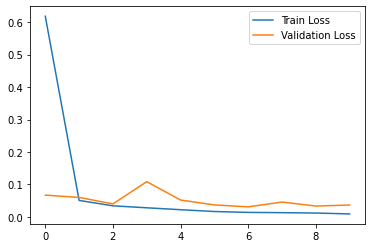

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.78it/s]


Testing loss: 0.02538887, Testing Accuracies: 0.99200000 
Testing finish!... plotting testing results


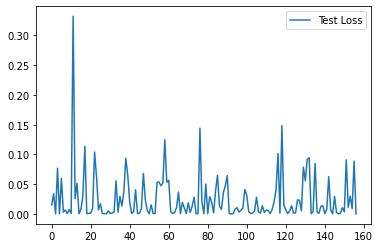

Training VGG on mnist with lr=0.0001 optimizer= SGD


100%|██████████| 188/188 [00:27<00:00,  6.79it/s]


Epoch 1 of 10 with 369.99 s
Training loss: 2.30253175, Validation loss: 2.30249021, Validation Accuracies: 0.09766667 


100%|██████████| 188/188 [00:27<00:00,  6.79it/s]


Epoch 2 of 10 with 370.13 s
Training loss: 2.30250692, Validation loss: 2.30245665, Validation Accuracies: 0.10300000 


100%|██████████| 188/188 [00:27<00:00,  6.78it/s]


Epoch 3 of 10 with 369.96 s
Training loss: 2.30248544, Validation loss: 2.30242225, Validation Accuracies: 0.10916667 


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 4 of 10 with 369.91 s
Training loss: 2.30246600, Validation loss: 2.30239862, Validation Accuracies: 0.11483333 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 5 of 10 with 370.05 s
Training loss: 2.30243833, Validation loss: 2.30236654, Validation Accuracies: 0.11641667 


100%|██████████| 188/188 [00:27<00:00,  6.79it/s]


Epoch 6 of 10 with 369.90 s
Training loss: 2.30241727, Validation loss: 2.30234601, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.82it/s]


Epoch 7 of 10 with 369.86 s
Training loss: 2.30239474, Validation loss: 2.30229916, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 8 of 10 with 369.74 s
Training loss: 2.30237297, Validation loss: 2.30227544, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 9 of 10 with 369.55 s
Training loss: 2.30235746, Validation loss: 2.30225197, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Epoch 10 of 10 with 369.29 s
Training loss: 2.30232875, Validation loss: 2.30222327, Validation Accuracies: 0.11683333 
Avg per epoch ptime: 369.84, total 10 epochs ptime: 3698.41
Training finish!... save and plotting training results


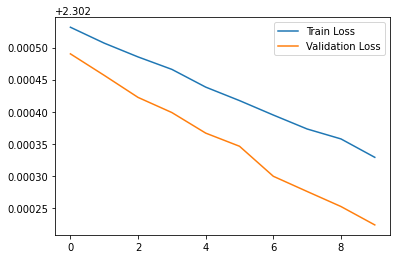

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.78it/s]


Testing loss: 2.30221057, Testing Accuracies: 0.11350000 
Testing finish!... plotting testing results


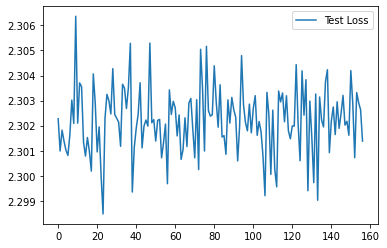

Training VGG on mnist with lr=0.01 optimizer= Adam


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 1 of 10 with 382.29 s
Training loss: 53065178.62693523, Validation loss: 2.30188853, Validation Accuracies: 0.10550000 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 2 of 10 with 382.46 s
Training loss: 2.30275059, Validation loss: 2.30025141, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 3 of 10 with 382.39 s
Training loss: 2.30245042, Validation loss: 2.30139863, Validation Accuracies: 0.11091667 


100%|██████████| 188/188 [00:27<00:00,  6.79it/s]


Epoch 4 of 10 with 382.51 s
Training loss: 2.30275150, Validation loss: 2.30114796, Validation Accuracies: 0.11566667 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 5 of 10 with 382.52 s
Training loss: 2.30271758, Validation loss: 2.30130320, Validation Accuracies: 0.11608333 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 6 of 10 with 382.38 s
Training loss: 2.30264307, Validation loss: 2.30209148, Validation Accuracies: 0.11391667 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 7 of 10 with 382.62 s
Training loss: 2.30268521, Validation loss: 2.30032473, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 8 of 10 with 382.51 s
Training loss: 2.30291713, Validation loss: 2.30065369, Validation Accuracies: 0.10966667 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 9 of 10 with 382.55 s
Training loss: 2.30245460, Validation loss: 2.30200283, Validation Accuracies: 0.09925000 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 10 of 10 with 382.49 s
Training loss: 2.30271934, Validation loss: 2.30053135, Validation Accuracies: 0.11683333 
Avg per epoch ptime: 382.47, total 10 epochs ptime: 3824.72
Training finish!... save and plotting training results


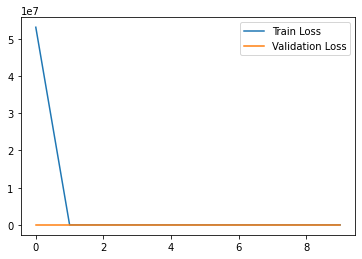

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.79it/s]


Testing loss: 2.30171005, Testing Accuracies: 0.11350000 
Testing finish!... plotting testing results


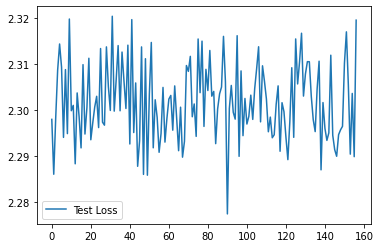

Training VGG on mnist with lr=0.01 optimizer= SGD


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 1 of 10 with 369.55 s
Training loss: 2.30201138, Validation loss: 2.30101953, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 2 of 10 with 369.58 s
Training loss: 2.30152290, Validation loss: 2.30069849, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.74it/s]


Epoch 3 of 10 with 370.04 s
Training loss: 2.30145547, Validation loss: 2.30057429, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.73it/s]


Epoch 4 of 10 with 369.94 s
Training loss: 2.30144731, Validation loss: 2.30052299, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.74it/s]


Epoch 5 of 10 with 369.92 s
Training loss: 2.30145134, Validation loss: 2.30053247, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.77it/s]


Epoch 6 of 10 with 369.80 s
Training loss: 2.30143621, Validation loss: 2.30050242, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.73it/s]


Epoch 7 of 10 with 369.89 s
Training loss: 2.30145316, Validation loss: 2.30050796, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Epoch 8 of 10 with 369.25 s
Training loss: 2.30144217, Validation loss: 2.30039414, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.83it/s]


Epoch 9 of 10 with 369.25 s
Training loss: 2.30145395, Validation loss: 2.30053685, Validation Accuracies: 0.11683333 


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Epoch 10 of 10 with 369.14 s
Training loss: 2.30145268, Validation loss: 2.30054093, Validation Accuracies: 0.11683333 
Avg per epoch ptime: 369.64, total 10 epochs ptime: 3696.38
Training finish!... save and plotting training results


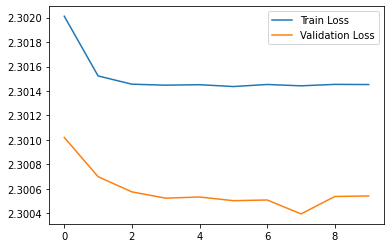

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.77it/s]


Testing loss: 2.30105405, Testing Accuracies: 0.11350000 
Testing finish!... plotting testing results


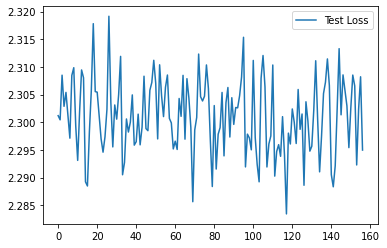

In [15]:
logger.info("Training VGG on MNIST dataset") 
print(datetime.today().strftime('%d-%m-%Y-%H-%M-%S'))

for lr in [0.0001, 0.01]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(mnist_save_dir+"/vgg_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
          print("Already trained on VGG on mnist with lr={} optimizer= {}".format(lr,optimizer))
  
          #model = VGG16(input_channels = 3, num_classes = 10)
          #model.load_state_dict(torch.load(mnist_save_dir+"/vgg_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt"))

        else:
          model = vgg()

          if optimizer == 'Adam':
              model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

          if optimizer == 'SGD':
              model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

          print("Training VGG on mnist with lr={} optimizer= {}".format(lr,optimizer))
      
          model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/mnist_VGG_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

          trained_model, train_hist = train_model(model, model_log_path, mnist_train_loader, mnist_val_loader, criterion, model_optimizer)
        
          print("Training finish!... save and plotting training results")

          with open(mnist_save_dir +'vgg_train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
              pickle.dump(train_hist, f)

          logger.info("Saving VGG trained model on  MNIST dataset") 
          torch.save(model.state_dict(), mnist_save_dir+"/vgg_mnist_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

          logger.info("Plotting VGG Model train losses on MNIST") 

          plt.plot(train_hist['model_train_losses'])
          plt.plot(train_hist['model_val_losses'])
          plt.legend(["Train Loss", "Validation Loss"])
          plt.savefig(mnist_fig_dir + "/vgg_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
          plt.show()

          print("Testing VGG trained model")
          test_loss = test_model(model, mnist_test_loader, criterion)
          print("Testing finish!... plotting testing results")
          plt.plot(test_loss)
          plt.legend(["Test Loss"])
          plt.savefig(mnist_fig_dir + "/vgg_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
          plt.show()
        print("========================================================")



# Training CIFAR 10 dataset on VGG

11-05-2022-14-00-39
Training VGG on cifar with lr=0.0001 optimizer= Adam


100%|██████████| 157/157 [00:23<00:00,  6.73it/s]


Epoch 1 of 10 with 318.74 s
Training loss: 2.30290946, Validation loss: 2.30271314, Validation Accuracies: 0.10210000 


100%|██████████| 157/157 [00:23<00:00,  6.73it/s]


Epoch 2 of 10 with 318.93 s
Training loss: 2.30282757, Validation loss: 2.30269935, Validation Accuracies: 0.09890000 


100%|██████████| 157/157 [00:23<00:00,  6.68it/s]


Epoch 3 of 10 with 319.18 s
Training loss: 2.30275369, Validation loss: 2.30282818, Validation Accuracies: 0.09770000 


100%|██████████| 157/157 [00:23<00:00,  6.70it/s]


Epoch 4 of 10 with 319.18 s
Training loss: 2.30274543, Validation loss: 2.30277104, Validation Accuracies: 0.09930000 


100%|██████████| 157/157 [00:23<00:00,  6.69it/s]


Epoch 5 of 10 with 319.41 s
Training loss: 2.30268904, Validation loss: 2.30276499, Validation Accuracies: 0.09890000 


100%|██████████| 157/157 [00:23<00:00,  6.69it/s]


Epoch 6 of 10 with 319.37 s
Training loss: 2.30266929, Validation loss: 2.30274421, Validation Accuracies: 0.09660000 


100%|██████████| 157/157 [00:23<00:00,  6.74it/s]


Epoch 7 of 10 with 319.14 s
Training loss: 2.30264720, Validation loss: 2.30272263, Validation Accuracies: 0.09800000 


100%|██████████| 157/157 [00:23<00:00,  6.69it/s]


Epoch 8 of 10 with 319.33 s
Training loss: 2.30263318, Validation loss: 2.30271076, Validation Accuracies: 0.09280000 


100%|██████████| 157/157 [00:23<00:00,  6.68it/s]


Epoch 9 of 10 with 319.56 s
Training loss: 2.30263146, Validation loss: 2.30272032, Validation Accuracies: 0.09660000 


100%|██████████| 157/157 [00:23<00:00,  6.68it/s]


Epoch 10 of 10 with 319.54 s
Training loss: 2.30263154, Validation loss: 2.30274335, Validation Accuracies: 0.09660000 
Avg per epoch ptime: 319.24, total 10 epochs ptime: 3192.40
Training finish!... save and plotting training results


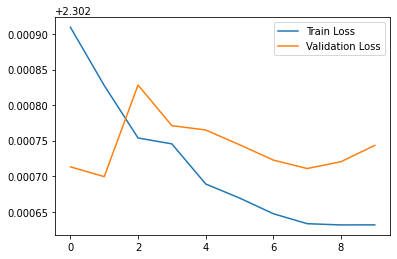

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.68it/s]


Testing loss: 2.30260599, Testing Accuracies: 0.08920000 
Testing finish!... plotting testing results


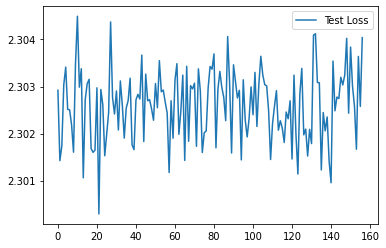

Training VGG on cifar with lr=0.0001 optimizer= SGD


100%|██████████| 157/157 [00:23<00:00,  6.67it/s]


Epoch 1 of 10 with 308.90 s
Training loss: 2.30261989, Validation loss: 2.30261561, Validation Accuracies: 0.09990000 


100%|██████████| 157/157 [00:23<00:00,  6.62it/s]


Epoch 2 of 10 with 309.14 s
Training loss: 2.30261799, Validation loss: 2.30263004, Validation Accuracies: 0.10070000 


100%|██████████| 157/157 [00:23<00:00,  6.64it/s]


Epoch 3 of 10 with 309.09 s
Training loss: 2.30261503, Validation loss: 2.30261660, Validation Accuracies: 0.09960000 


100%|██████████| 157/157 [00:23<00:00,  6.65it/s]


Epoch 4 of 10 with 309.11 s
Training loss: 2.30261372, Validation loss: 2.30263416, Validation Accuracies: 0.10170000 


100%|██████████| 157/157 [00:23<00:00,  6.64it/s]


Epoch 5 of 10 with 309.00 s
Training loss: 2.30262133, Validation loss: 2.30260098, Validation Accuracies: 0.10190000 


100%|██████████| 157/157 [00:23<00:00,  6.66it/s]


Epoch 6 of 10 with 308.66 s
Training loss: 2.30261184, Validation loss: 2.30261455, Validation Accuracies: 0.09780000 


100%|██████████| 157/157 [00:23<00:00,  6.68it/s]


Epoch 7 of 10 with 308.74 s
Training loss: 2.30260874, Validation loss: 2.30258801, Validation Accuracies: 0.10060000 


100%|██████████| 157/157 [00:23<00:00,  6.68it/s]


Epoch 8 of 10 with 308.70 s
Training loss: 2.30260265, Validation loss: 2.30263042, Validation Accuracies: 0.09760000 


100%|██████████| 157/157 [00:23<00:00,  6.64it/s]


Epoch 9 of 10 with 308.87 s
Training loss: 2.30261374, Validation loss: 2.30262080, Validation Accuracies: 0.09930000 


100%|██████████| 157/157 [00:23<00:00,  6.66it/s]


Epoch 10 of 10 with 308.84 s
Training loss: 2.30261317, Validation loss: 2.30260531, Validation Accuracies: 0.10240000 
Avg per epoch ptime: 308.90, total 10 epochs ptime: 3089.05
Training finish!... save and plotting training results


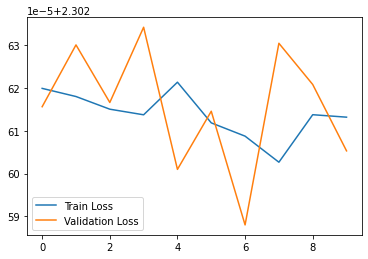

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.65it/s]


Testing loss: 2.30249072, Testing Accuracies: 0.10060000 
Testing finish!... plotting testing results


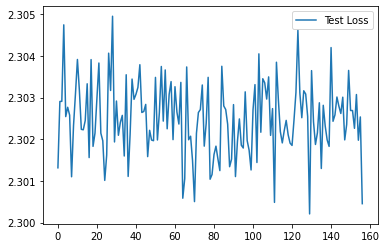

Training VGG on cifar with lr=0.01 optimizer= Adam


100%|██████████| 157/157 [00:23<00:00,  6.62it/s]


Epoch 1 of 10 with 319.78 s
Training loss: 149158439.59949446, Validation loss: 2.30266924, Validation Accuracies: 0.10080000 


100%|██████████| 157/157 [00:23<00:00,  6.61it/s]


Epoch 2 of 10 with 319.78 s
Training loss: 2.30351935, Validation loss: 2.30464973, Validation Accuracies: 0.09660000 


100%|██████████| 157/157 [00:23<00:00,  6.65it/s]


Epoch 3 of 10 with 319.83 s
Training loss: 2.30356873, Validation loss: 2.30371024, Validation Accuracies: 0.10260000 


100%|██████████| 157/157 [00:23<00:00,  6.65it/s]


Epoch 4 of 10 with 319.78 s
Training loss: 2.30370776, Validation loss: 2.30307255, Validation Accuracies: 0.10210000 


100%|██████████| 157/157 [00:23<00:00,  6.59it/s]


Epoch 5 of 10 with 319.99 s
Training loss: 2.30377082, Validation loss: 2.30418509, Validation Accuracies: 0.10080000 


100%|██████████| 157/157 [00:23<00:00,  6.61it/s]


Epoch 6 of 10 with 319.82 s
Training loss: 2.30338881, Validation loss: 2.30445693, Validation Accuracies: 0.09660000 


100%|██████████| 157/157 [00:23<00:00,  6.61it/s]


Epoch 7 of 10 with 319.87 s
Training loss: 2.30342348, Validation loss: 2.30353984, Validation Accuracies: 0.10210000 


100%|██████████| 157/157 [00:23<00:00,  6.61it/s]


Epoch 8 of 10 with 319.69 s
Training loss: 2.30348319, Validation loss: 2.30434102, Validation Accuracies: 0.09870000 


100%|██████████| 157/157 [00:23<00:00,  6.62it/s]


Epoch 9 of 10 with 319.68 s
Training loss: 2.30369950, Validation loss: 2.30282750, Validation Accuracies: 0.10210000 


100%|██████████| 157/157 [00:23<00:00,  6.62it/s]


Epoch 10 of 10 with 319.64 s
Training loss: 2.30339717, Validation loss: 2.30385876, Validation Accuracies: 0.10340000 
Avg per epoch ptime: 319.79, total 10 epochs ptime: 3197.87
Training finish!... save and plotting training results


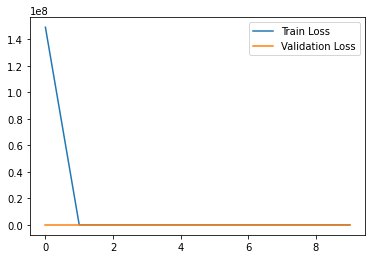

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.56it/s]


Testing loss: 2.30375082, Testing Accuracies: 0.09580000 
Testing finish!... plotting testing results


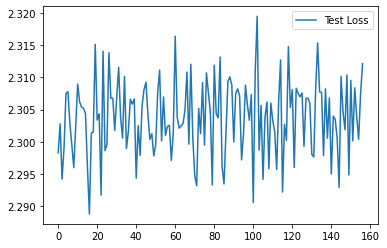

Training VGG on cifar with lr=0.01 optimizer= SGD


100%|██████████| 157/157 [00:23<00:00,  6.57it/s]


Epoch 1 of 10 with 309.20 s
Training loss: 2.30267312, Validation loss: 2.30268806, Validation Accuracies: 0.10000000 


100%|██████████| 157/157 [00:24<00:00,  6.54it/s]


Epoch 2 of 10 with 309.44 s
Training loss: 2.30265793, Validation loss: 2.30271993, Validation Accuracies: 0.09610000 


100%|██████████| 157/157 [00:23<00:00,  6.56it/s]


Epoch 3 of 10 with 309.40 s
Training loss: 2.30266451, Validation loss: 2.30273247, Validation Accuracies: 0.09660000 


100%|██████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch 4 of 10 with 309.52 s
Training loss: 2.30266067, Validation loss: 2.30273721, Validation Accuracies: 0.09660000 


100%|██████████| 157/157 [00:24<00:00,  6.51it/s]


Epoch 5 of 10 with 309.75 s
Training loss: 2.30264924, Validation loss: 2.30277087, Validation Accuracies: 0.09600000 


100%|██████████| 157/157 [00:24<00:00,  6.51it/s]


Epoch 6 of 10 with 309.80 s
Training loss: 2.30265479, Validation loss: 2.30272622, Validation Accuracies: 0.09800000 


100%|██████████| 157/157 [00:24<00:00,  6.48it/s]


Epoch 7 of 10 with 309.62 s
Training loss: 2.30265603, Validation loss: 2.30274609, Validation Accuracies: 0.09640000 


100%|██████████| 157/157 [00:24<00:00,  6.49it/s]


Epoch 8 of 10 with 309.73 s
Training loss: 2.30265720, Validation loss: 2.30275480, Validation Accuracies: 0.09430000 


100%|██████████| 157/157 [00:24<00:00,  6.48it/s]


Epoch 9 of 10 with 309.71 s
Training loss: 2.30265163, Validation loss: 2.30282868, Validation Accuracies: 0.09800000 


100%|██████████| 157/157 [00:24<00:00,  6.51it/s]


Epoch 10 of 10 with 309.35 s
Training loss: 2.30265210, Validation loss: 2.30278111, Validation Accuracies: 0.09690000 
Avg per epoch ptime: 309.55, total 10 epochs ptime: 3095.54
Training finish!... save and plotting training results


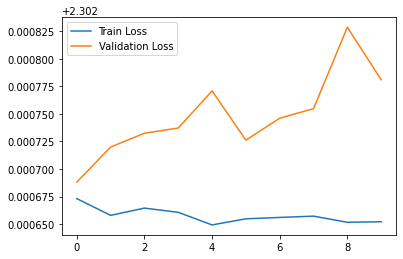

Testing VGG trained model


100%|██████████| 157/157 [00:23<00:00,  6.54it/s]


Testing loss: 2.30261767, Testing Accuracies: 0.08920000 
Testing finish!... plotting testing results


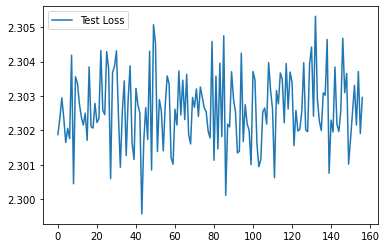

In [16]:
logger.info("Trianing VGG on CIFAR dataset") 
print(datetime.today().strftime('%d-%m-%Y-%H-%M-%S'))

for lr in [0.0001, 0.01]:
    for optimizer in ['Adam', 'SGD']:
        print("========================================================")
        #Cross Entropy Loss function
        criterion = nn.CrossEntropyLoss()

        if os.path.isfile(cifar_save_dir+"/vgg_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt"):
          print("Already trained on VGG on cifar with lr={} optimizer= {}".format(lr,optimizer))
          print("Loading Model")
          #model = VGG16(input_channels = 3, num_classes = 10)
          #model.load_state_dict(torch.load(cifar_save_dir+"/vgg_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt"))
          

        else:
          model = vgg()

          if optimizer == 'Adam':
              model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)

          if optimizer == 'SGD':
              model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

          print("Training VGG on cifar with lr={} optimizer= {}".format(lr,optimizer))
      
          model_log_path = 'content/drive/MyDrive/DLCV_CW3/run_logs/cifar_VGG_train_lr-{}_opt-{}_'.format(lr,optimizer) +datetime.today().strftime("%d-%m-%Y-%H-%M-%S")

          trained_model, train_hist = train_model(model, model_log_path, cifar_train_loader, cifar_val_loader, criterion, model_optimizer)
        
          print("Training finish!... save and plotting training results")

          with open(cifar_save_dir +'vgg_train_hist_lr-{}_opt-{}_'.format(lr,optimizer)+datetime.today().strftime("%d-%m-%Y-%H-%M-%S")+'.pkl', 'wb') as f:
              pickle.dump(train_hist, f)

          logger.info("Saving VGG trained model on CIFAR dataset") 
          torch.save(model.state_dict(), cifar_save_dir+"/vgg_cifar_lr-{}_opt-{}_".format(lr,optimizer)+".pt") 

          logger.info("Plotting VGG Model train losses on CIFAR") 

          plt.plot(train_hist['model_train_losses'])
          plt.plot(train_hist['model_val_losses'])
          plt.legend(["Train Loss", "Validation Loss"])
          plt.savefig(cifar_fig_dir + "/vgg_train_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
          plt.show()

          print("Testing VGG trained model")
          test_loss = test_model(model, mnist_test_loader, criterion)
          print("Testing finish!... plotting testing results")
          plt.plot(test_loss)
          plt.legend(["Test Loss"])
          plt.savefig(cifar_fig_dir + "/vgg_test_val_loss_lr-{}_opt-{}_".format(lr,optimizer)+".png") 
          plt.show()
        print("========================================================")

